In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from Bio.Seq import Seq
from Bio import motifs
import random

np.random.seed(1337)

%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

## General Utility Functions For Data Processing

In [2]:
def test_data(df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(df[obs_col].values.reshape(-1,1))   #LAE: .values added, pd deprecation
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df


def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

## Load Data and Create Train/Test Datasets

In [12]:
#df = pd.read_pickle('../data/egfp_unmod_1.pkl')  #LAE: do not have this pickle file...?
df = pd.read_csv('../data/egfp_unmod_1.csv')
df.sort_values('total_reads', inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.iloc[:280000]

# The training set has 260k UTRs and the test set has 20k UTRs.
e_test = df.iloc[:20000]
e_train = df.iloc[20000:]

# Scale the training mean ribosome load values
# LAE: added .values before reshape due to pandas naming deprecation
e_train.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))
e_test.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(e_test.loc[:,'rl'].values.reshape(-1,1))

## Create Alternate Encoding 

Each sequence gets a vector of scalars: in-frame starts, in-frame stops, out-of-frame starts, out-of-frame stops

In [4]:
def encode_counts(df, col='utr'):
    vectors = np.zeros([len(df),4])
    for i,seq in enumerate(df[col].values):  
        f1 = [ seq[j:j+3] for j in range(0, len(seq), 3) ] # out-of-frame by 2 ahead
        f2 = [ seq[j:j+3] for j in range(1, len(seq), 3) ] #b/c 50bp % 3 = 1, THIS ONE is in-frame
        f3 = [ seq[j:j+3] for j in range(2, len(seq), 3) ] # out-of-frame by 1 ahead
        n_inf_start = f2.count('ATG') 
        n_otf_start = f1.count('ATG')+f3.count('ATG')
        # n_inf_alt_start = f2.count('CTG')
        # n_otf_alt_start = f1.count('CTG')+f3.count('CTG')
        n_inf_stop = f2.count('TAA')+f2.count('TAG')+f2.count('TGA')
        n_otf_stop = f1.count('TAA')+f1.count('TAG')+f1.count('TGA')+f3.count('TAA')+f3.count('TAG')+f3.count('TGA')
        vectors[i][0],vectors[i][1] = n_inf_start,n_otf_start
        # vectors[i][2],vectors[i][3] = n_inf_alt_start,n_otf_alt_start
        vectors[i][2],vectors[i][3] = n_inf_stop,n_otf_stop
    return vectors

In [5]:
seq_e_train = encode_counts(e_train)
seq_e_test = encode_counts(e_test)

done


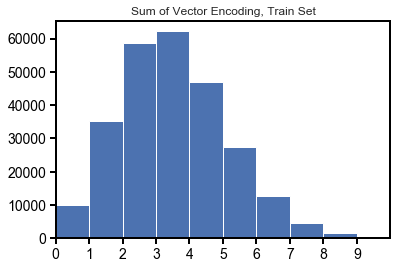

In [6]:
counts_train = [ sum(s) for s in seq_e_train ]
counts_test = [ sum(s) for s in seq_e_test ]

plt.hist(counts_train,bins=12)
plt.xticks(range(10))
plt.xlim(0,10)
plt.title("Sum of Vector Encoding, Train Set")
print 'done'

Text(0.5,1,'Sum of Vector Encoding, Test Set')

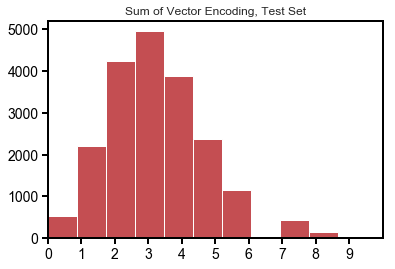

In [7]:
plt.hist(counts_test,bins=15,color='r')
plt.xticks(range(10))
plt.xlim(0,10)
plt.title("Sum of Vector Encoding, Test Set")

In [8]:
e_train.loc[:,'vector_sum'] = counts_train
e_test.loc[:,'vector_sum'] = counts_test

## Create Model Structure (Random Forest) & Train Model

In [9]:
def train_model(train_data,train_labels,n_trees=250,warm_start=True,iterations=5):
    ''' Build model archicture and fit.'''
    model = RandomForestRegressor(n_estimators=n_trees,criterion='mse',warm_start=warm_start)
    n = len(train_data) / iterations
    model.fit(train_data[:n],train_labels[:n])
    for i in range(2,iterations):
        model.fit(train_data[n*(i-1):n*i],train_labels[n*(i-1):n*i])
        model.n_estimators += n_trees
        print model.score(train_data,train_labels)
    return model

In [10]:
rfr0 = train_model(seq_e_train,label_e_train,n_trees=5,iterations=1)
print rfr0.score(seq_e_train,label_e_train), rfr0.score(seq_e_test,label_e_test)

0.520120559325864 -10.246484486970695


In [11]:
rfr1 = train_model(seq_e_train,label_e_train,n_trees=20,iterations=1)
print rfr1.score(seq_e_train,label_e_train), rfr1.score(seq_e_test,label_e_test)

0.5202556632266189 -10.242445930959493


In [12]:
rfr2 = train_model(seq_e_train,label_e_train,n_trees=100,iterations=1)
print rfr2.score(seq_e_train,label_e_train), rfr2.score(seq_e_test,label_e_test)

0.5202864567588806 -10.242013029993737


In [13]:
rfr3 = train_model(seq_e_train,label_e_train,n_trees=2000,iterations=1)
print rfr3.score(seq_e_train,label_e_train), rfr3.score(seq_e_test,label_e_test)

0.5202944886608835 -10.24210902881515


In [14]:
def train_model_sets(train_data_sets,train_label_sets,n_trees=10,warm_start=True):
    ''' Build model archicture and fit.'''
    model = RandomForestRegressor(n_estimators=n_trees,criterion='mse',warm_start=warm_start)
    for data,labels in zip(train_data_sets,train_label_sets):
        model.fit(data,labels)
        model.n_estimators += n_trees
    return model

In [15]:
# Split data so it fits in memory (batch size was 128, going to 130 for even split)
batch_size = 130
train_data_sets = np.split(seq_e_train,(len(seq_e_train)/batch_size))
train_label_sets = np.split(label_e_train,(len(seq_e_train)/batch_size))

In [16]:
# rfr5 = train_model_sets(train_data_sets,train_label_sets,n_trees=5,warm_start=True)
# print rfr5.score(seq_e_train,label_e_train)
# print rfr5.score(seq_e_test,label_e_test)

Notably, the batched 10k model doesn't do as well as the 2000 unit one-shot model!

In [17]:
# This one was a bit too big...
#rfr6 = train_model_sets(train_data_sets,train_label_sets,n_trees=25,warm_start=True)
#print rfr6.score(seq_e_train,label_e_train)
#print rfr6.score(seq_e_test,label_e_test)

In [42]:
# Compute Test r-squared Results
e_test = test_data(e_test,rfr0,seq_e_test,'rl',output_col="5u_pred")
r = r2(e_test['rl'],e_test['5u_pred'])
print r
e_test = test_data(e_test,rfr1,seq_e_test,'rl',output_col="20u_pred")
r = r2(e_test['rl'],e_test['20u_pred'])
print r
e_test = test_data(e_test,rfr2,seq_e_test,'rl',output_col="100u_pred")
r = r2(e_test['rl'],e_test['100u_pred'])
print r
e_test = test_data(e_test,rfr3,seq_e_test,'rl',output_col="2000u_pred")
r = r2(e_test['rl'],e_test['2000u_pred'])
print r
# e_test = test_data(e_test,rfr5,seq_e_test,'rl',output_col="10ku_split_pred")
# r = r2(e_test['rl'],e_test['10ku_split_pred'])
# print r

0.600589538715998
0.6007320396638766
0.6007436995490676
0.6007147752215855


In [43]:
# Compute Train r-squared Results results
e_train = test_data(e_train,rfr0,seq_e_train,'rl',output_col="5u_pred")
r = r2(e_train['rl'],e_train['5u_pred'])
print r
e_train = test_data(e_train,rfr1,seq_e_train,'rl',output_col="20u_pred")
r = r2(e_train['rl'],e_train['20u_pred'])
print r
e_train = test_data(e_train,rfr2,seq_e_train,'rl',output_col="100u_pred")
r = r2(e_train['rl'],e_train['100u_pred'])
print r
e_train = test_data(e_train,rfr3,seq_e_train,'rl',output_col="2000u_pred")
r = r2(e_train['rl'],e_train['2000u_pred'])
print r
# e_train = test_data(e_train,rfr5,seq_e_train,'rl',output_col="10ku_split_pred")
# r = r2(e_train['rl'],e_train['10ku_split_pred'])
# print r

0.5201219435358114
0.5202559640400619
0.5202864715379812
0.5202944959203001


In [23]:
# Make Plotting Function for Reuseability
def jointgrid_plot(datasets,one_dataset=False,colors=[(0.3, 0.45, 0.69),'r'],title="",alphas=[0.1,0.1],
                   xheader='rl',yheader='pred'):
    """
    Make a jointgrid scatter plot of Observed MRL vs Predicted MRL using two or more different datasets 
    colored according to the input list of colors, in a style like the author's figure. 
    If only one dataset, set the flag one_dataset to True so that datasets can be of type list without 
    getting datasets vs dataset elements confused. Bad code but hey.
    """
    data = datasets if one_dataset == True else datasets[0]
    
    g = sns.JointGrid(x=xheader, y=yheader, data=data, space=0, xlim=(1,10), ylim=(0,10), ratio=6, size=7)
    g.plot_joint(plt.scatter,s=20, color=colors[0], linewidth=0.2, alpha=str(alphas[0]), edgecolor='white')
    f = g.fig
    ax = f.gca()
    ax.set_yticks(np.arange(0,9.01, 1));
    ax.set_yticklabels(range(10),size=20);
    ax.set_xticks(np.arange(1,10.01, 1));
    ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(0,9)
    ax.set_xlim(1,10)
    g.plot_marginals(sns.kdeplot,shade=colors[0], **{'linewidth':2, 'color':colors[0]})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});

    if one_dataset == False:
        alphas = alphas if len(alphas) == len(datasets) else [alphas[0]]*len(datasets)
        for d,c,a in zip(datasets[1:],colors[1:],alphas[1:]):
            g.x = d[xheader].values
            g.y = d[yheader].values
            g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=str(a), color=c, edgecolor='white')
            g.plot_marginals(sns.kdeplot, shade=c, **{'linewidth':2, 'color':c})
            f = g.fig

    f.suptitle(title,fontsize=20)
    
    return f

/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


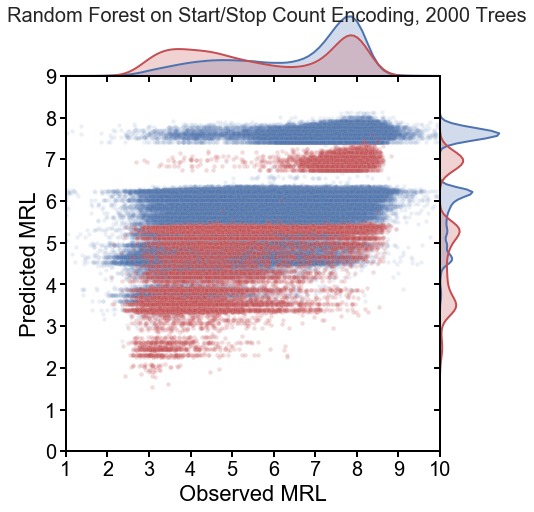

In [21]:
train_test_plot = jointgrid_plot([e_train,e_test],
                                  title='Random Forest on Start/Stop Count Encoding, 2000 Trees',
                                  alphas=[0.1,0.2],
                                  yheader='2000u_pred')

## Create Alternate Datasets Based On Information Content

As per conversation with Stephen and Mike on 9.10, see if the random forest works better on the sequences that have more information, which would suggest that the encoding is the limiting factor, not the random forest's imputation ability

In [44]:
#these are the seqs that have total data more than 3
hi_train_utrs = [ s for e,s in zip(seq_e_train,e_train['utr'].values) if sum(e) > 5 ]
hi_test_utrs = [ s for e,s in zip(seq_e_test,e_test['utr'].values) if sum(e) > 5 ]

train_hi = e_train[ e_train['utr'].isin(hi_train_utrs) ]
test_hi = e_test[ e_test['utr'].isin(hi_test_utrs) ]

In [47]:
#seq_test_hi = encode_counts(test_hi)
#seq_train_hi = encode_counts(train_hi)

#test_hi = test_data(test_hi,rfr3,seq_test_hi,'rl',output_col="2000u_pred")  #these are already computed!
r = r2(test_hi['rl'],test_hi['20u_pred'])
print r
#train_hi = test_data(train_hi,rfr3,seq_train_hi,'rl',output_col="2000u_pred") #these are already computed!
r = r2(train_hi['rl'],train_hi['20u_pred'])
print r

# test_hi = test_data(test_hi,rfr5,seq_test_hi,'rl',output_col="10ku_split_pred")
# r = r2(test_hi['rl'],test_hi['10ku_split_pred'])
# train_hi = test_data(train_hi,rfr5,seq_train_hi,'rl',output_col="10ku_split_pred")
# r = r2(train_hi['rl'],train_hi['10ku_split_pred'])

0.3804791970761213
0.36139012039302887


In [49]:
train_low = e_train[ ~e_train['utr'].isin(hi_train_utrs) ]
test_low =  e_test[ ~e_test['utr'].isin(hi_test_utrs) ]
print r2(test_low['rl'],test_low['20u_pred'])
print r2(test_low['rl'],test_low['20u_pred'])

0.6054148365891439
0.6054148365891439


In [27]:
train_hi.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(train_hi.loc[:,'rl'].values.reshape(-1,1))

In [28]:
rfr_hi = train_model(seq_train_hi,train_hi['scaled_rl'].values,n_trees=2000,iterations=1)
print rfr_hi.score(seq_train_hi,train_hi['rl']), rfr_hi.score(seq_test_hi,test_hi['rl'])

-12.536088243676266 -11.799965760580294


In [29]:
test_hi = test_data(test_hi,rfr_hi,seq_test_hi,'rl',output_col="2000u_hi_pred")
r = r2(test_hi['rl'],test_hi['2000u_hi_pred'])
train_hi = test_data(train_hi,rfr_hi,seq_train_hi,'rl',output_col="2000u_hi_pred")
r = r2(train_hi['rl'],train_hi['2000u_hi_pred'])

In [30]:
e_test = test_data(e_test,rfr_hi,seq_e_test,'rl',output_col="2000u_hi_pred")
r = r2(e_test['rl'],e_test['2000u_hi_pred'])
print r
e_train = test_data(e_train,rfr_hi,seq_e_train,'rl',output_col="2000u_hi_pred")
r = r2(e_train['rl'],e_train['2000u_hi_pred'])
print r

0.6017689574372223
0.5112930443240107


### Does Testing and/or Training on the High-Vector-Sum Data Improve Results?

In [31]:
r = r2(e_train['rl'],e_train['2000u_hi_pred'])
print "High-trained RFR on Full Train Data", "\t", r
r = r2(e_train['rl'],e_train['2000u_pred'])
print "Normal RFR on Full Train Data","\t\t",r
r = r2(e_test['rl'],e_test['2000u_hi_pred'])
print "High-trained RFR on Full Test Data","\t", r
r = r2(e_test['rl'],e_test['2000u_pred'])
print "Normal RFR on Full Test Data","\t\t",r
print
r = r2(train_hi['rl'],train_hi['2000u_hi_pred'])
print "High-trained RFR on High Train Data","\t", r
r = r2(train_hi['rl'],train_hi['2000u_pred'])
print "Normal RFR on High Train Data","\t\t",r
r = r2(test_hi['rl'],test_hi['2000u_hi_pred'])
print "High-trained RFR on High Test Data","\t", r
r = r2(test_hi['rl'],test_hi['2000u_pred'])
print "Normal RFR on High Test Data","\t\t",r


High-trained RFR on Full Train Data 	0.5112930443240107
Normal RFR on Full Train Data 		0.5202944959203001
High-trained RFR on Full Test Data 	0.6017689574372223
Normal RFR on Full Test Data 		0.6007147752215855

High-trained RFR on High Train Data 	0.36177893983407355
Normal RFR on High Train Data 		0.36178900839498
High-trained RFR on High Test Data 	0.38114812764821043
Normal RFR on High Test Data 		0.38038684439431364


In [51]:
r = r2(e_train['rl'],e_train['2000u_pred'])
print "RFR on Full Train Data", "\t\t", r
r = r2(train_low['rl'],train_low['2000u_pred'])
print "RFR on Low (<= 5) Train Data", "\t", r
r = r2(train_hi['rl'],train_hi['2000u_pred'])
print "RFR on High (> 5) Train Data", "\t", r
print
r = r2(e_test['rl'],e_test['2000u_pred'])
print "RFR on Full Test Data","\t\t",r
r = r2(test_low['rl'],test_low['2000u_pred'])
print "RFR on Low (<= 5) Train Data", "\t", r
r = r2(test_hi['rl'],test_hi['2000u_pred'])
print "RFR on High (> 5) Train Data", "\t", r


RFR on Full Train Data 		0.5202944959203001
RFR on Low (<= 5) Train Data 	0.5144604158305283
RFR on High (> 5) Train Data 	0.3617890083949807

RFR on Full Test Data 		0.6007147752215855
RFR on Low (<= 5) Train Data 	0.6053797726005794
RFR on High (> 5) Train Data 	0.380386844394314


### ANSWER: Not Really

Can we see what this looks like in more detail with plotting?  


From the plots, it looks like for the very high-info UTRs (aka vector sum 9+), they are distinctly more lying-along-the-y=x-line (aka accurate) than the lower-info UTRs, so it might be that total info matters in the extreme case, but is not predictive for the bulk of the sequences? See trend in yellow vs blue vs purple data, several graphs down)

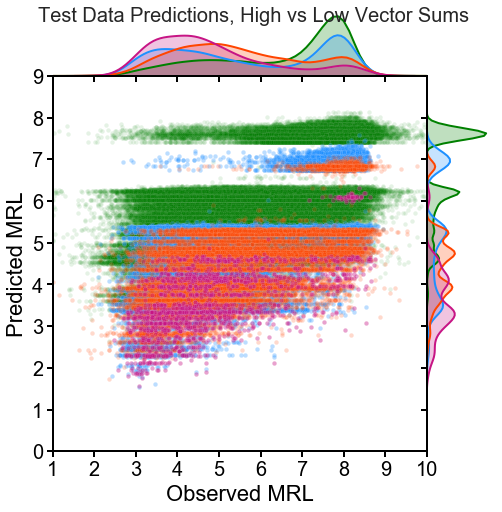

In [38]:
p = jointgrid_plot([e_train,e_test,train_hi,test_hi],
                                  title='Test Data Predictions, High vs Low Vector Sums',
                                  colors=['green','dodgerblue','orangered','mediumvioletred'],
                                  alphas=[0.1,0.3,0.2,0.4],
                                  yheader='2000u_pred')

Nope, doesn't seem like the high vector sum test set is any more successful.


### What if we plot stratified by Vector Sum?

Lots of plots to follow

In [88]:
data = pd.concat([e_test,e_train],axis=0)
data.head(2)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,0,1,10,100u_pred,11,12,13,2,2000u_hi_pred,2000u_pred,...,r6,r7,r8,r9,rl,scaled_rl,total,total_reads,utr,vector_sum
0,0.000137,0.000109,0.000015,3.524916,0.000015,0.000013,0.000017,0.000057,4.305492,3.526304,...,0.020343,0.019850,0.017988,0.019283,3.039939,NaN,0.000463,12126.0,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCGGCTA,3.0
1,0.000067,0.000070,0.000016,5.120970,0.000016,0.000016,0.000015,0.000065,5.716128,5.118379,...,0.028540,0.027431,0.024766,0.024241,3.895109,NaN,0.000395,10368.0,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTATAGT,2.0


In [89]:
e =  encode_counts(data)
z = [ s for i,s in enumerate(data['utr'].values) if np.sum(e[i]) < 1 ]
data_zeros = data[ data['utr'].isin(z) ]
data_nonzero = data[ ~data['utr'].isin(data_zeros['utr'].values)]

ns = [ s for i,s in enumerate(data['utr'].values) if (e[i][0]+e[i][1]) < 1 ]
nt = [ s for i,s in enumerate(data['utr'].values) if (e[i][2]+e[i][3]) < 1 ]
data_nostart = data[ data['utr'].isin(ns) ]
data_nostop = data[ data['utr'].isin(nt) ]
data_rest = data[ ~data['utr'].isin(ns+nt) ]

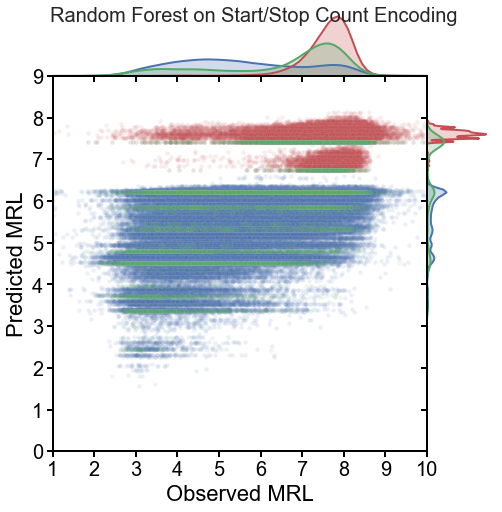

In [90]:
train_test_plot2 = jointgrid_plot([data_rest,data_nostart,data_nostop],
                                  title='Random Forest on Start/Stop Count Encoding',
                                  colors = ['b','r','g'],
                                  yheader='2000u_pred')

In [91]:
e_train.loc[:,'2000u_error'] = np.abs(e_train['2000u_pred'] - e_train['rl']) / e_train['rl'] 
e_test.loc[:,'2000u_error'] = np.abs(e_test['2000u_pred'] - e_test['rl']) / e_test['rl'] 
data.loc[:,'2000u_error'] = np.abs(data['2000u_pred'] - data['rl']) / data['rl']

In [92]:
# numbers = [ data[data['vector_sum'] == i ] for i in range(14)]
# train_test_plot2 = jointgrid_plot(numbers,
#                                   title='Random Forest on Start/Stop Count Encoding, Colored by Total Information',
#                                   colors = ['crimson','r','orange','gold','limegreen','g','dodgerblue',
#                                             'b','blueviolet','purple','mediumvioletred','slategrey','black'],
#                                   yheader='2000u_pred')

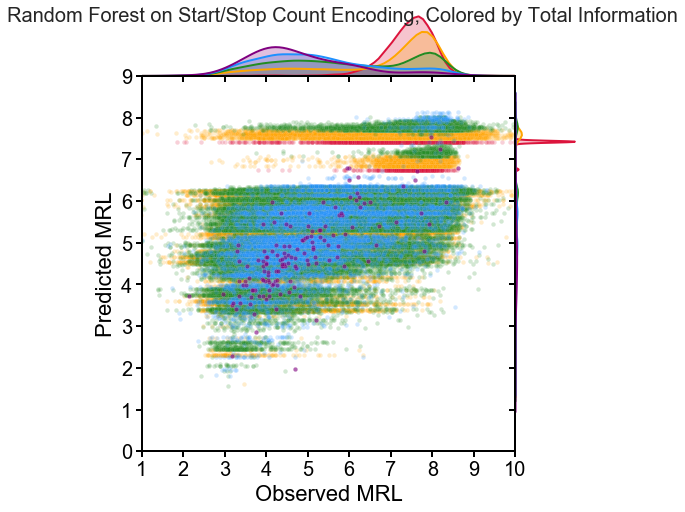

In [93]:
numbers2 = [ data[data['vector_sum'].isin(t) ] for t in [ (0,0,0),(1,2,3),(4,5,6),(7,8,9),(10,11,12,13) ] ]
train_test_plot2 = jointgrid_plot(numbers2,
                                  title='Random Forest on Start/Stop Count Encoding, Colored by Total Information',
                                  colors = ['crimson','orange','forestgreen','dodgerblue','purple',],
                                  alphas = [ 0.2,0.2,0.2,0.2,0.6],
                                  yheader='2000u_pred')

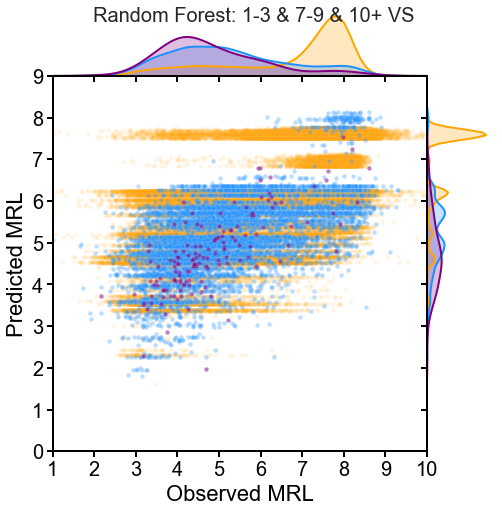

In [94]:
train_test_plot2 = jointgrid_plot([numbers2[1],numbers2[3],numbers2[4]],
                                  title='Random Forest: 1-3 & 7-9 & 10+ VS',
                                  colors = ['orange', 'dodgerblue','purple'],
                                  alphas=[0.1, 0.3,0.5],
                                  yheader='2000u_pred')

(0, 1)

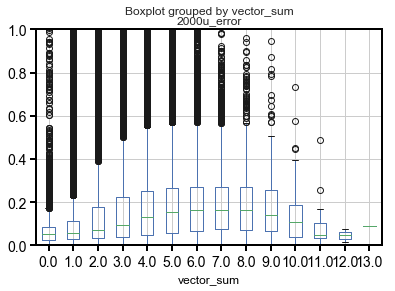

In [95]:
box = data.boxplot(column='2000u_error',by='vector_sum')
box.set_ylim(0,1)

### Yeah, this seems pretty inconclusive. I don't think the PRIMARY driver of prediction quality is vector sum, here, but it does seem like if you have a LARGE amount of data your error is lower.


now, on to the next question...  


# Is this the best the Encoding can do, or is the limit the RF?

Try training a Neural Network with the same encoding to see if it can do better, and if so how much

In [17]:
import keras
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv1D

Using TensorFlow backend.


In [ ]:
nn = keras.models.load_model('./saved_models/3lCountEncode_nn.hdf5')

In [97]:
# # build the NN model
# nn = Sequential()
# nn.add(Dense(500,input_shape=(4,)))
# nn.add(Activation('relu'))
# nn.add(Dropout(0))
# nn.add(Dense(100))
# nn.add(Activation('relu'))
# nn.add(Dropout(0.1))
# nn.add(Dense(50))
# nn.add(Activation('relu'))
# nn.add(Dropout(0.1))
    
# nn.add(Dense(1))
# nn.add(Activation('linear'))

# np.random.seed(1337)

# #compile the model
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# nn.compile(loss='mean_squared_error', optimizer=adam)

# #fit the model
# nn.fit(seq_e_train, e_train['scaled_rl'], batch_size=128, epochs=10, verbose=1)

W0916 17:38:07.289571 4482835904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0916 17:38:07.306559 4482835904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 17:38:07.312439 4482835904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 17:38:07.353638 4482835904 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0916 17:38:07.362848 4482835904 deprecati

Epoch 1/10
260000/260000 [==============================] - 6s 23us/step - loss: 0.4955
Epoch 2/10
260000/260000 [==============================] - 6s 22us/step - loss: 0.4890
Epoch 3/10
260000/260000 [==============================] - 6s 23us/step - loss: 0.4882
Epoch 4/10
260000/260000 [==============================] - 4s 17us/step - loss: 0.4873
Epoch 5/10
260000/260000 [==============================] - 5s 19us/step - loss: 0.4870
Epoch 6/10
260000/260000 [==============================] - 5s 18us/step - loss: 0.4863
Epoch 7/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.4863: 0
Epoch 8/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.4860
Epoch 9/10
260000/260000 [==============================] - 5s 19us/step - loss: 0.4861
Epoch 10/10
260000/260000 [==============================] - 5s 20us/step - loss: 0.4859


In [98]:
e_test = test_data(e_test,nn,seq_e_test,'rl',output_col="nn_pred")
r = r2(e_test['rl'],e_test['nn_pred'])
print r
e_train = test_data(e_train,nn,seq_e_train,'rl',output_col='nn_pred')
r = r2(e_train['rl'],e_train['nn_pred'])
print r

0.6011108767436509
0.5190031179445634


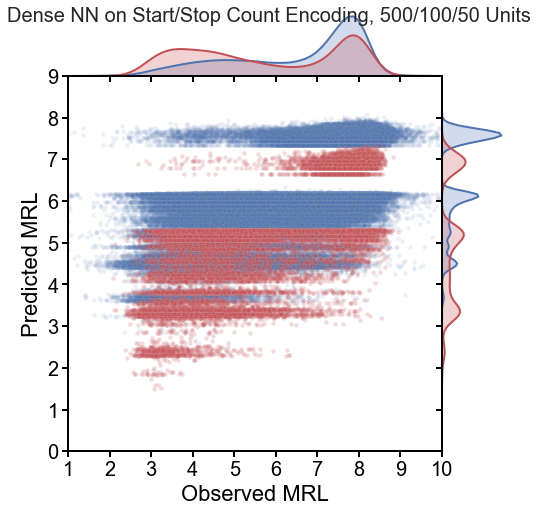

In [99]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='Dense NN on Start/Stop Count Encoding, 500/100/50 Units',
                                  alphas=[0.1,0.2],
                                  yheader='nn_pred')

## ANSWER: Seems like the encoding is the bottleneck?

Encoding doesn't appear to have enough information to generalize well; or at least, with this particular encoding, a 3-layer dense neural network (500, 100, and 50 neurons per layer) trained for 10 epochs with 0, 0.1, and 0.2 dropout does not perform appreciably better on either the test or train dataset than a Random Forest Regressor with 2000 trees. The loss during training rapidly reaches about 0.52 in the second epoch and does not decrease appreciably from there for the rest of training, suggesting the limit in the encoding has been reached


Interestingly, the test data looks much more linear than the train data, with that upper off-diagonal chunk messing up the r2...

## Try to do One-Hot Encoding that will work with an RFR and a CNN

Looking at Kangway's notebooks for a model of how to do it...

In [ ]:
preprocessing.StandardScaler().fit_transform(e_train.loc[:,'rl'].values.reshape(-1,1))

In [13]:
# train on these, convert model predictions back from the -1 -> 1 range using the same scaler
# (the test_data function does this for us)
scaled_y_train = e_train['scaled_rl'] 
scaled_y_test = e_test['scaled_rl']

raw_y_train = e_train['rl']
raw_y_train = e_test['rl']

In [11]:
# One-Hot Base Pair Encoding, All on One Line
nuc_d = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1], 'N':[0,0,0,0]}


X_train_cnn = np.empty([len(e_train),50*4,1])
X_test_cnn = np.empty([len(e_test),50*4,1])
X_train_cnn2 = np.empty([len(e_train),1,50*4]) #try the other shape for vector encoding, in case that is relevant?
X_test_cnn2 = np.empty([len(e_test),1,50*4])   # see the examples below 
X_train_rfr = np.empty([len(e_train),50*4])
X_test_rfr = np.empty([len(e_test),50*4])


for i,seq in enumerate(e_train['utr'].values): 
    seq = seq.upper()
    a = np.array([nuc_d[x] for x in seq]).flatten()
    X_train_rfr[i] = a
    X_train_cnn[i] = a.reshape(200,1)
    X_train_cnn2[i] = a.reshape(1,200)
for i,seq in enumerate(e_test['utr'].values): 
    seq = seq.upper()
    a = np.array([nuc_d[x] for x in seq]).flatten()
    X_test_rfr[i] = a
    X_test_cnn[i] = a.reshape(200,1)
    X_test_cnn2[i] = a.reshape(1,200)


In [14]:
#Encoding Example
a = ['GGG','TAT']
vectors = np.empty([2,1,3*4])
for i,s in enumerate(a):
    print s
    b = np.array([nuc_d[x] for x in s])
    print b
    print "Flat", b.flatten()
    print "1xN", b.reshape(1,12)
    print "Nx1", b.reshape(12,1)
    print

GGG
[[0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]
Flat [0 0 1 0 0 0 1 0 0 0 1 0]
1xN [[0 0 1 0 0 0 1 0 0 0 1 0]]
Nx1 [[0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]]

TAT
[[0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]]
Flat [0 0 0 1 1 0 0 0 0 0 0 1]
1xN [[0 0 0 1 1 0 0 0 0 0 0 1]]
Nx1 [[0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]]



In [15]:
# Load the models
cnn = keras.models.load_model('./saved_models/4lFlatOneHotEncode_cnn.hdf5')
cnn2 = keras.models.load_model('./saved_models/4lFlatOneHotEncode2_cnn.hdf5')

In [18]:
# build the CNN model
cnn = Sequential()

cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=60, 
                 kernel_size=24,strides=4) ) #strides=4 b/c want to go forwards one bp at a time, aka 4 places
cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 
cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 
cnn.add(Conv1D(activation="relu", input_shape=(200,1),
                 padding="same", filters=30, 
                 kernel_size=24,strides=4) ) 

cnn.add(Flatten())
cnn.add(Dense(30))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.2))
    
cnn.add(Dense(1))
cnn.add(Activation('linear'))


W0920 14:53:19.018151 4540855744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0920 14:53:19.034224 4540855744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0920 14:53:19.037513 4540855744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0920 14:53:19.146783 4540855744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0920 14:53:19.154031 4540855744 deprecati

In [20]:
np.random.seed(1337)

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
cnn.compile(loss='mean_squared_error', optimizer=adam)

# fit the model
cnn.fit(X_train_cnn, scaled_y_train, batch_size=128, epochs=10, verbose=1)

W0920 14:53:32.511529 4540855744 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
260000/260000 [==============================] - 36s 137us/step - loss: 0.2731
Epoch 2/10
260000/260000 [==============================] - 35s 136us/step - loss: 0.1470
Epoch 3/10
260000/260000 [==============================] - 36s 139us/step - loss: 0.1375
Epoch 4/10
260000/260000 [==============================] - 32s 122us/step - loss: 0.1315
Epoch 5/10
260000/260000 [==============================] - 34s 131us/step - loss: 0.1282
Epoch 6/10
260000/260000 [==============================] - 33s 125us/step - loss: 0.1256
Epoch 7/10
260000/260000 [==============================] - 32s 123us/step - loss: 0.1230
Epoch 8/10
260000/260000 [==============================] - 30s 115us/step - loss: 0.1208
Epoch 9/10
260000/260000 [==============================] - 33s 128us/step - loss: 0.1180
Epoch 10/10
260000/260000 [==============================] - 31s 118us/step - loss: 0.1170


In [21]:
e_test = test_data(e_test,cnn,X_test_cnn,'rl',output_col="cnn_pred")
r = r2(e_test['rl'],e_test['cnn_pred'])
print r
e_train = test_data(e_train,cnn,X_train_cnn,'rl',output_col="cnn_pred")
r = r2(e_train['rl'],e_train['cnn_pred'])
print r

0.9385801123462657
0.909237778473879


/usr/local/lib/python2.7/site-packages/seaborn/axisgrid.py:1672: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


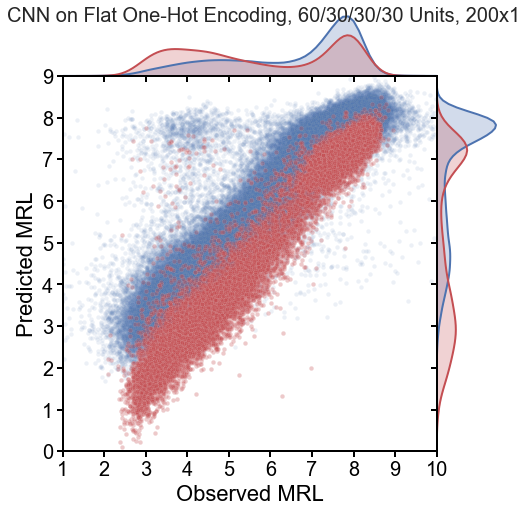

In [24]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='CNN on Flat One-Hot Encoding, 60/30/30/30 Units, 200x1',
                                  alphas=[0.1,0.3],
                                  yheader='cnn_pred')

In [ ]:
# Try the other vector shape, just to check!
# cnn2 = Sequential()
# cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
#                  padding="same", filters=60, 
#                  kernel_size=24,strides=4) ) #strides=4 b/c want to go forwards one bp at a time, aka 4 places
# cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
#                  padding="same", filters=30, 
#                  kernel_size=24,strides=4) ) 
# cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
#                  padding="same", filters=30, 
#                  kernel_size=24,strides=4) ) 
# cnn2.add(Conv1D(activation="relu", input_shape=(1,200),
#                  padding="same", filters=30, 
#                  kernel_size=24,strides=4) ) 
# cnn2.add(Flatten())
# cnn2.add(Dense(30))
# cnn2.add(Activation('relu'))
# cnn2.add(Dropout(0.2))
# cnn2.add(Dense(1))
# cnn2.add(Activation('linear'))

In [ ]:
# np.random.seed(1337)

# #compile the model
# adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
# cnn2.compile(loss='mean_squared_error', optimizer=adam)

# # fit the model
# cnn2.fit(X_train_cnn2, y_train, batch_size=128, epochs=10, verbose=1)

0.6993212225565746
0.6360561800224303


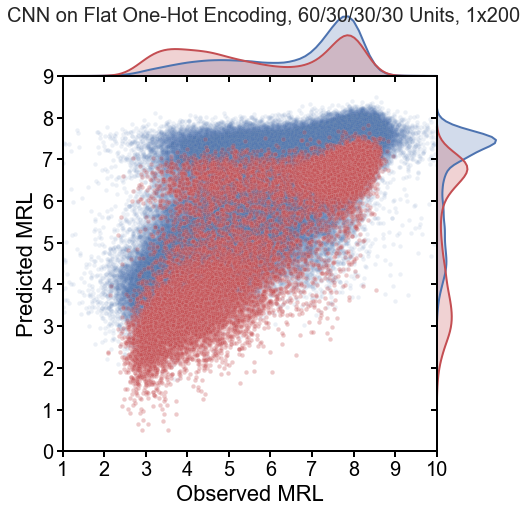

In [107]:
# e_test = test_data(e_test,cnn2,X_test_cnn2,'rl',output_col="cnn2_pred")
# r = r2(e_test['rl'],e_test['cnn2_pred'])
# print r
# e_train = test_data(e_train,cnn2,X_train_cnn2,'rl',output_col="cnn2_pred")
# r = r2(e_train['rl'],e_train['cnn2_pred'])
# print r

# train_test_plot3 = jointgrid_plot([e_train,e_test],
#                                   title='CNN on Flat One-Hot Encoding, 60/30/30/30 Units, 1x200',
#                                   alphas=[0.1,0.3],
#                                   yheader='cnn2_pred')

#### I see, 200x1 vs 1x200 is VERY different. Interesting!

Wow, the 200x1 is as good or better than their CNN, just as a note. Hmm cool.

In [ ]:
#Save NN Models
# nn.save('./saved_models/3lCountEncode_nn.hdf5')
# cnn.save('./saved_models/4lFlatOneHotEncode_cnn.hdf5')
# cnn2.save('./saved_models/4lFlatOneHotEncode2_cnn.hdf5')

## Now Try Random Forest With Same Encoding

In [25]:
np.random.seed(1337)
rfr_mini = RandomForestRegressor(n_estimators=5,criterion='mse',warm_start=True,verbose=1)
rfr_mini.fit(X_train_rfr,scaled_y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   51.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=True)

In [27]:
np.random.seed(1337)
rfr_small = RandomForestRegressor(n_estimators=10,criterion='mse',warm_start=True,verbose=1)
rfr_small.fit(X_train_rfr,scaled_y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.7min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=True)

In [31]:
e_test = test_data(e_test,rfr_mini,X_test_rfr,'rl',output_col="rfrm_pred")
r = r2(e_test['rl'],e_test['rfrm_pred'])
print r
e_train = test_data(e_train,rfr_mini,X_train_rfr,'rl',output_col="rfrm_pred")
r = r2(e_train['rl'],e_train['rfrm_pred'])
print r
e_test = test_data(e_test,rfr_small,X_test_rfr,'rl',output_col="rfrs_pred")
r = r2(e_test['rl'],e_test['rfrs_pred'])
print r
e_train = test_data(e_train,rfr_small,X_train_rfr,'rl',output_col="rfrs_pred")
r = r2(e_train['rl'],e_train['rfrs_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


0.09062406534904013


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.7989225882910329


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


0.13705887808696693


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.1s finished


0.8815788999493119


## Whaaaaat is going on here? Why are the test sets wayyy worse, like 0.8 r2 apart??

Also really interesting, if indeed this plot is valid and I didn't make some code error somewhere, is that the off-diagonal points are NONEXISTANT

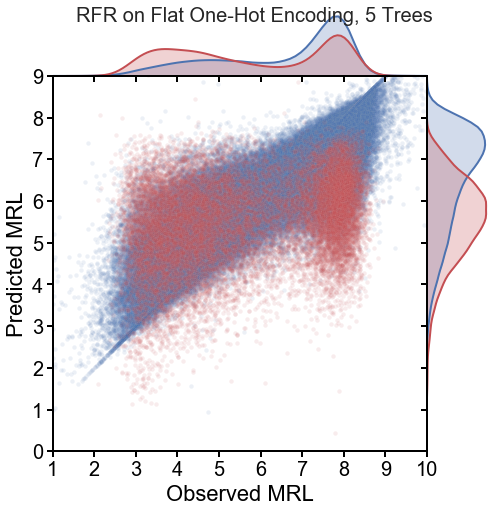

In [30]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 5 Trees',
                                  alphas=[0.1,0.1],
                                  yheader='rfrm_pred')

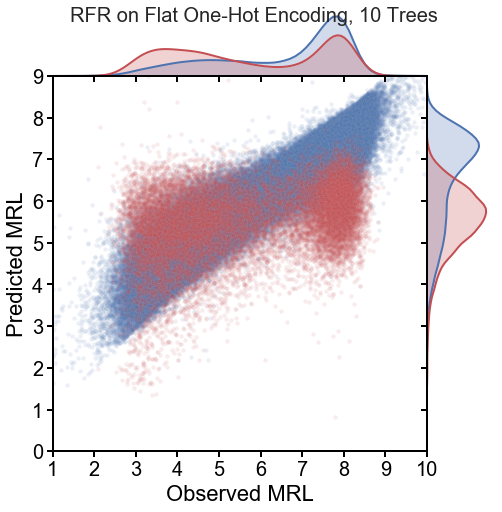

In [32]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 10 Trees',
                                  alphas=[0.1,0.1],
                                  yheader='rfrs_pred')

## What if we strictly limit depth, but use more trees?

as per conversation with Mike and Stephen

In [79]:
# With max depth = 10 and max_features = 20, run a simple experiment
# by slowly increasing n_estimators and seeing the effect
n_est = [5,10,20,50,100,2000,]
testR2 = [0.09,0.1253,0.158,0.1766,0.1914,0.19636]
trainR2 = [0.1302,0.1716,0.2064,0.2275,0.244,0.2483]

In [76]:
np.random.seed(1337)
rfr_sh1 = RandomForestRegressor(n_estimators=2000,criterion='mse',max_depth=10,max_features=20,
                                 warm_start=True,verbose=1)
rfr_sh1.fit(X_train_rfr,scaled_y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed: 24.1min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=None, oob_score=False,
           random_state=None, verbose=1, warm_start=True)

In [77]:
e_test = test_data(e_test,rfr_sh1,X_test_rfr,'rl',output_col="rfrsh1_pred")
r = r2(e_test['rl'],e_test['rfrsh1_pred'])
print r
e_train = test_data(e_train,rfr_sh1,X_train_rfr,'rl',output_col="rfrsh1_pred")
r = r2(e_train['rl'],e_train['rfrsh1_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    3.8s finished


0.19636403345058245


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.24834645187035853


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:   57.7s finished


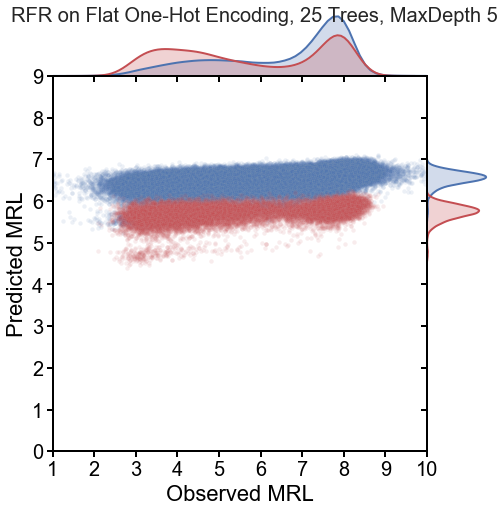

In [78]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 25 Trees, MaxDepth 5',
                                  alphas=[0.1,0.1],
                                  yheader='rfrsh1_pred')

In [ ]:
np.random.seed(1337)
rfr_sh2 = RandomForestRegressor(n_estimators=100,criterion='mse',max_depth=5,
                                 warm_start=True,verbose=1)
rfr_sh2.fit(X_train_rfr,scaled_y_train)

## What does this look like with MORE trees?

In [76]:
np.random.seed(1337)
rfr = RandomForestRegressor(n_estimators=100,criterion='mse',verbose=1)
rfr.fit(X_train_rfr,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 17.4min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [77]:
e_test = test_data(e_test,rfr,X_test_rfr,'rl',output_col="rfr_pred")
r = r2(e_test['rl'],e_test['rfr_pred'])
print r
e_train = test_data(e_train,rfr,X_train_rfr,'rl',output_col="rfr_pred")
r = r2(e_train['rl'],e_train['rfr_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.5s finished


0.23850296946528154


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.2s finished


0.9721581053308644


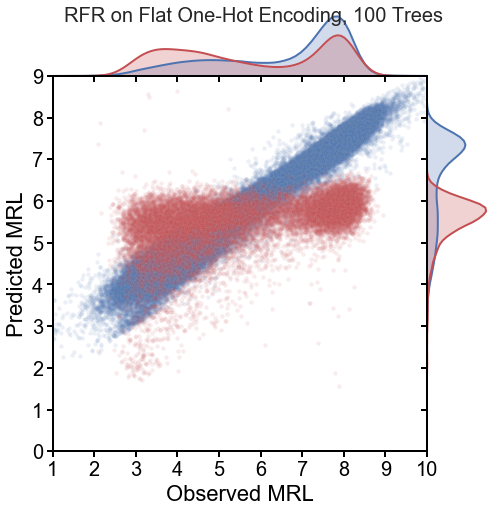

In [78]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 100 Trees',
                                  alphas=[0.1,0.1],
                                  yheader='rfr_pred')

In [79]:
import pickle
# Save RFRs
pickle.dump(rfr, open('./saved_models/100treeOH_rfr.sav', 'wb'))
pickle.dump(rfr_small, open('./saved_models/10treeOH_rfr.sav', 'wb'))
pickle.dump(rfr_mini, open('./saved_models/5treeOH_rfr.sav', 'wb'))
pickle.dump(rfr5, open('./saved_models/10ktreeVC_rfr.sav', 'wb'))
pickle.dump(rfr3, open('./saved_models/2ktreeVC_rfr.sav', 'wb'))

In [88]:
one_tree = rfr_mini.estimators_[0]

from sklearn.tree import export_graphviz
import os

# Export as dot file
export_graphviz(one_tree, out_file='./plots/5trOH_rfr_tr0.dot', 
                max_depth=10,
                rounded = True, proportion = False, 
                precision = 2, filled = True)


## couldn't get dotfile conversion to png to work...

#os.system('dot -Tpng ./plots/5trOH_rfr.dot -o ./plots/5trOH_rfr.png -Gdpi=600')

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', './plots/5trOH_rfr_tr0.dot', '-o', './plots/5trOH_rfr_tr0.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = './plots/5trOH_rfr_tr0.png')

## Try Limiting Tree Depth

In [49]:
# How big are they right now?
print "MINI TREES"
for est in rfr_mini.estimators_:
    print est.tree_.max_depth
print "SMALL TREES"
for est in rfr_small.estimators_:
    print est.tree_.max_depth

MINI TREES
37
37
36
37
37
SMALL TREES
37
37
36
37
37
38
39
35
37
35


In [42]:
np.random.seed(1337)
rfr_lims = RandomForestRegressor(n_estimators=10,criterion='mse',warm_start=True,verbose=1,max_depth=20)
rfr_lims.fit(X_train_rfr,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.6min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=True)

In [43]:
e_test = test_data(e_test,rfr_lims,X_test_rfr,'rl',output_col="10tr20d_pred")
r = r2(e_test['rl'],e_test['10tr20d_pred'])
print r
e_train = test_data(e_train,rfr_lims,X_train_rfr,'rl',output_col="10tr20d_pred")
r = r2(e_train['rl'],e_train['10tr20d_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


0.1431058681884505


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


0.8511012667783369


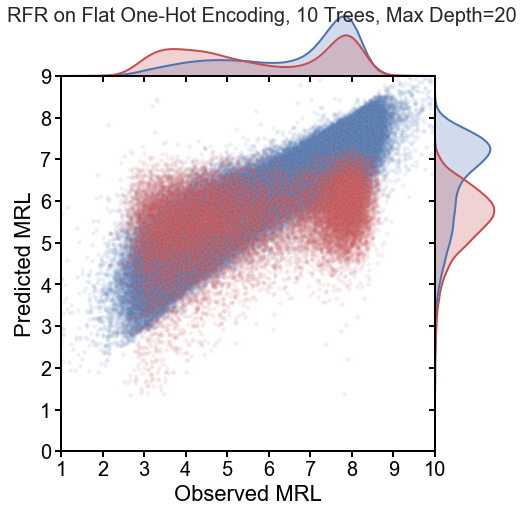

In [50]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat One-Hot Encoding, 10 Trees, Max Depth=20',
                                  alphas=[0.1,0.1],
                                  yheader='10tr20d_pred')

## Try a Scalar Encoding, In Case the skip-by-4 is Messing Up the RFR

In [115]:
X_train_scalar = np.zeros([len(e_train),50])
X_test_scalar = np.zeros([len(e_test),50])
X_train_scalar_cnn = np.zeros([len(e_train),50,1])
X_test_scalar_cnn = np.zeros([len(e_test),50,1])

scalar_d = { 'A':1, 'G':1.5, 'C':2.5, 'T':3 }

for i,seq in enumerate(e_train['utr'].values): 
    seq = seq.upper()
    a = np.array([scalar_d[x] for x in seq])
    X_train_scalar[i] = a
    X_train_scalar_cnn[i] = a.reshape(50,1)
for i,seq in enumerate(e_test['utr'].values): 
    seq = seq.upper()
    a = np.array([scalar_d[x] for x in seq]).flatten()
    X_test_scalar[i] = a
    X_test_scalar_cnn[i] = a.reshape(50,1)

In [134]:
X_train_scalar_alt = X_train_scalar.transpose()
X_train_scalar_alt

array([[2.5, 1. , 2.5, ..., 1.5, 2.5, 2.5],
       [2.5, 1. , 2.5, ..., 1.5, 2.5, 2.5],
       [1.5, 3. , 1.5, ..., 3. , 1.5, 1.5],
       ...,
       [2.5, 3. , 2.5, ..., 1. , 1.5, 1.5],
       [1. , 2.5, 3. , ..., 3. , 1.5, 1. ],
       [2.5, 1. , 1. , ..., 1. , 1. , 1. ]])

In [154]:
np.random.seed(1337)
rfr_scalar_20t = RandomForestRegressor(n_estimators=20,criterion='mse',warm_start=True,verbose=1,
                                      max_depth=30,max_features=20)
rfr_scalar_20t.fit(X_train_scalar,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   34.9s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=None, oob_score=False,
           random_state=None, verbose=1, warm_start=True)

In [155]:
e_test = test_data(e_test,rfr_scalar_5t,X_test_scalar,'rl',output_col="rfr_sc20t_pred")
r = r2(e_test['rl'],e_test['rfr_sc20t_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


0.02863028022800568


In [156]:
e_train = test_data(e_train,rfr_scalar_5t,X_train_scalar,'rl',output_col="rfr_sc20t_pred")
r = r2(e_train['rl'],e_train['rfr_sc20t_pred'])
print r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


0.7395870093617898


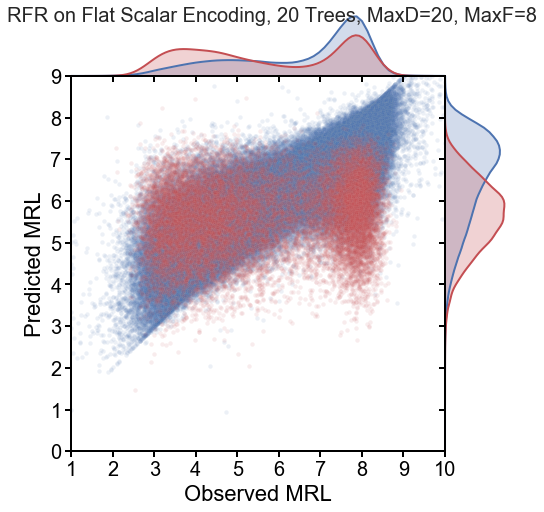

In [153]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat Scalar Encoding, 20 Trees, MaxD=20, MaxF=8',
                                  alphas=[0.1,0.1],
                                  yheader='rfr_sc20t_pred')

In [129]:
np.random.seed(1337)
rfr_scalar_10t = RandomForestRegressor(n_estimators=10,criterion='mse',warm_start=True,verbose=1,max_depth=20)
rfr_scalar_10t.fit(X_train_scalar,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   35.2s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=1, warm_start=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


0.09733374131008911


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


0.8605196400557005


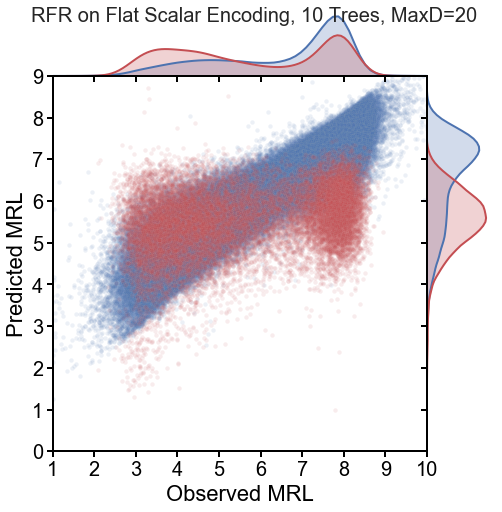

In [130]:
e_test = test_data(e_test,rfr_scalar_10t,X_test_scalar,'rl',output_col="rfr_sc10t_pred")
r = r2(e_test['rl'],e_test['rfr_sc10t_pred'])
print r
e_train = test_data(e_train,rfr_scalar_10t,X_train_scalar,'rl',output_col="rfr_sc10t_pred")
r = r2(e_train['rl'],e_train['rfr_sc10t_pred'])
print r

train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='RFR on Flat Scalar Encoding, 10 Trees, MaxD=20',
                                  alphas=[0.1,0.1],
                                  yheader='rfr_sc10t_pred')

In [119]:
# build the CNN model
cnns = Sequential()

cnns.add(Conv1D(activation="relu", input_shape=(50,1),
                 padding="same", filters=60, 
                 kernel_size=8) ) 
cnns.add(Conv1D(activation="relu", input_shape=(50,1),
                 padding="same", filters=30, 
                 kernel_size=8) ) 
cnns.add(Conv1D(activation="relu", input_shape=(50,1),
                 padding="same", filters=30, 
                 kernel_size=8) ) 
cnns.add(Conv1D(activation="relu", input_shape=(50,1),
                 padding="same", filters=30, 
                 kernel_size=8) ) 

cnns.add(Flatten())
cnns.add(Dense(30))
cnns.add(Activation('relu'))
cnns.add(Dropout(0.2))
    
cnns.add(Dense(1))
cnns.add(Activation('linear'))

In [120]:
np.random.seed(1337)

#compile the model
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
cnns.compile(loss='mean_squared_error', optimizer=adam)

# fit the model
cnns.fit(X_train_scalar_cnn, y_train, batch_size=128, epochs=10, verbose=1)

Epoch 1/10
260000/260000 [==============================] - 62s 240us/step - loss: 0.4530
Epoch 2/10
260000/260000 [==============================] - 59s 227us/step - loss: 0.2406
Epoch 3/10
260000/260000 [==============================] - 63s 242us/step - loss: 0.2133
Epoch 4/10
260000/260000 [==============================] - 62s 240us/step - loss: 0.1983
Epoch 5/10
260000/260000 [==============================] - 61s 235us/step - loss: 0.1835
Epoch 6/10
260000/260000 [==============================] - 59s 228us/step - loss: 0.1768
Epoch 7/10
260000/260000 [==============================] - 62s 239us/step - loss: 0.1715
Epoch 8/10
260000/260000 [==============================] - 65s 249us/step - loss: 0.1681
Epoch 9/10
260000/260000 [==============================] - 61s 235us/step - loss: 0.1652
Epoch 10/10
260000/260000 [==============================] - 66s 255us/step - loss: 0.1632


In [124]:
e_test = test_data(e_test,cnns,X_test_scalar_cnn,'rl',output_col="cnn_sc_pred")
r = r2(e_test['rl'],e_test['cnn_sc_pred'])
print r
e_train = test_data(e_train,cnns,X_train_scalar_cnn,'rl',output_col="cnn_sc_pred")
r = r2(e_train['rl'],e_train['cnn_sc_pred'])
print r

0.9175432410885003
0.8779351318493657


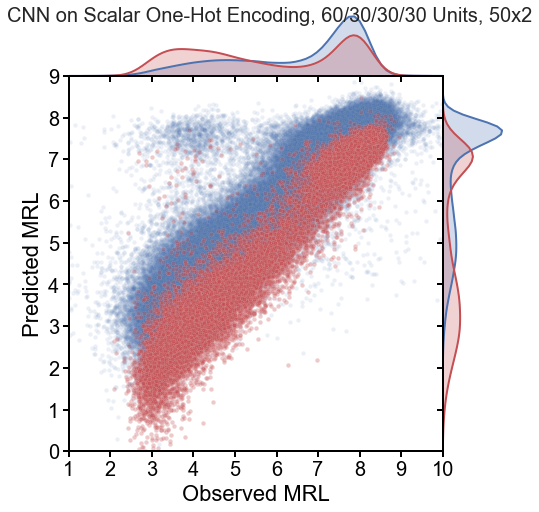

In [125]:
train_test_plot3 = jointgrid_plot([e_train,e_test],
                                  title='CNN on Scalar Encoding, 60/30/30/30 Units, 50x1',
                                  alphas=[0.1,0.3],
                                  yheader='cnn_sc_pred')